# Logistic Regression

**Basic Description**

Logisitc regression is one of the simplest and most popular classification algorithms. In logistic regression, a linear output is converted into a probability between 0 and 1 using the sigmoid function. Logistic regression is highly interprettable and easier to explain than other models.

**Bias-Variance Tradeoff** 

Its simplicity makes for high bias and low variance.

**Upsides**

It's quick to implement and can serve as a good baseline for performance.

**Downsides**

It generally does not perform well with non-linear decision boundaries. When interprettability is desireably, it's important that features are not correlated.

**Other Notes**

## Load Packages and Prep Data

In [16]:
# custom utils
import utils
print(utils.__file__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression



/Users/shea/Projects/ancient_toolmaking/utils.py


In [17]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [34]:
# load data
X_train, y_train, X_test, y_test = utils.load_data()

X_train (62889, 42)
y_train (62889,)
X_test (15723, 42)
y_test (15723,)


## Model 1
- Default hyperparameters
- Notable
    - penalty='l2'
    - C=1.0
    - max_iter=100

### Fit Model

In [41]:
# fit logistic regression model
log_1 = LogisticRegression(max_iter=200)
x = log_1.fit(X_train, y_train)

### Cross validation

In [42]:
# cross validation with f1 scoring
score = utils.f1_cv(log_1, X_train, y_train)

[0.5198 0.5028 0.4952 0.4939 0.4959]
0.5015


## Model 2
- Regularize by selecting important features from recursive feature elimination ranking

### Feature Selection

In [21]:
# recursive feature elimination to determine feature importance
log = LogisticRegression(max_iter = 200)
model_rfe = RFECV(log, cv = 5)
x = model_rfe.fit(X_train, y_train)

In [22]:
# feature ranking
rfe = model_rfe.ranking_
features = X_train.columns
rfe_df = pd.DataFrame({'features': features, 'rfe_rank': rfe})
rfe_df.sort_values(by = 'rfe_rank', ascending = True)

,features,rfe_rank
20,solidity,1
36,fiber_width,1
35,fiber_length,1
34,ellipticity,1
33,angularity,1
30,t_w_ratio,1
29,w_t_ratio,1
27,l_w_ratio,1
25,curvature,1
24,transparency,1


In [23]:
# features ranked 1 are the most important
# select only the more important features as a means of regularization
selected_features = rfe_df[rfe_df['rfe_rank'] == 1]['features'].values
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [24]:
# 16 important features
X_train_selected.shape

(62889, 16)

### Fit Model

In [25]:
# fit logistic regression model
# using max_iter 400 to avoid error message
# using X_train_new to select only the 16 features that were selected
log_2 = LogisticRegression(max_iter = 400)
x = log_2.fit(X_train_selected, y_train)

### Cross validation

In [26]:
# cross validation with f1 scoring
score = utils.f1_cv(log_2, X_train, y_train)

[0.5198 0.5028 0.4952 0.4939 0.4959]
0.5015


## Model 3
- Adjust hyperparameters

### Fit Model

In [27]:
# tried a variety of different combinations of parameters
# same selected features as the original model
log_3 = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
x = log_3.fit(X_train, y_train)

### Cross-Validation
- Slight improvement

In [28]:
# cross validation with f1 scoring
score = utils.f1_cv(log_3, X_train, y_train)

[0.4817 0.4535 0.4656 0.4754 0.4551]
0.4663


## Model 4
- Account for imbalance in training data
- Adjust class weights to favor minority class detection
- Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/Introduction.html

In [36]:
y_train.value_counts()


0    58675
1     4214
Name: stone_soil_enc, dtype: int64

In [37]:
imbalance_ratio = y_train.value_counts()[1] / y_train.value_counts()[0]
print(imbalance_ratio)

# underweight the majority class (0)
class_weight={0:imbalance_ratio,1:1}

0.07181934384320408


In [47]:
# fit logistic regression model
log_4 = LogisticRegression(max_iter = 200, class_weight=class_weight)
x = log_4.fit(X_train, y_train)

In [48]:
# cross validation with f1 scoring
score = utils.f1_cv(log_4, X_train, y_train)

[0.4365 0.4405 0.4296 0.4311 0.4343]
0.4344


## Compare Default and Weighted

In [55]:
print('accuracy')
score = cross_val_score(log_1, X_train, y_train, scoring = "accuracy")
print(score.mean())
score = cross_val_score(log_4, X_train, y_train, scoring = "accuracy")
print(score.mean())

print()

print('recall')
score = cross_val_score(log_1, X_train, y_train, scoring = "recall")
print(score.mean())
score = cross_val_score(log_4, X_train, y_train, scoring = "recall")
print(score.mean())

print()

print('precision')
score = cross_val_score(log_1, X_train, y_train, scoring = "precision")
print(score.mean())
score = cross_val_score(log_4, X_train, y_train, scoring = "precision")
print(score.mean())

print()

print('f1')
score = cross_val_score(log_1, X_train, y_train, scoring = "f1")
print(score.mean())
score = cross_val_score(log_4, X_train, y_train, scoring = "f1")
print(score.mean())

accuracy
0.9508817093920403
0.8582105058092587

recall
0.3687692129962271
0.8125290572353572

precision
0.7838161839477161
0.2964838391517931

f1
0.5015221824997407
0.43440520666859667


## Test Performance
Final test performance of model chosen using best cross-validation scores. These scores will be used to select amongst different model types.

Accuracy:	0.9467022832792724
Precision:	0.7878787878787878
Recall:		0.31152073732718893
F1:		0.4464993394980185


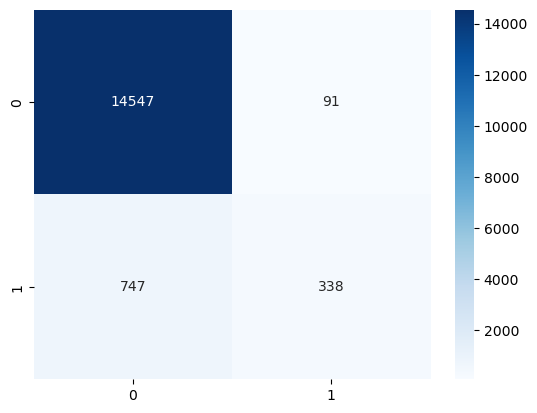

In [53]:
# test the performance of the selected model
y_pred = log_1.predict(X_test)

utils.pred_metrics(y_test,y_pred)

# confusion matrix
utils.cm_plot(y_test,y_pred)

Accuracy:	0.8955034026585257
Precision:	0.3742110009017133
Recall:		0.7649769585253456
F1:		0.5025734181047533


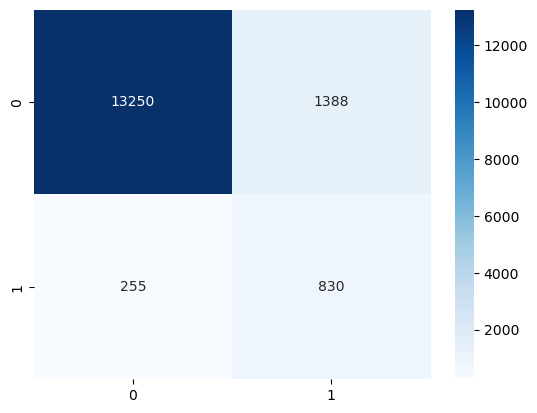

In [52]:
# test the performance of the selected model
y_pred = log_4.predict(X_test)

utils.pred_metrics(y_test,y_pred)

# confusion matrix
utils.cm_plot(y_test,y_pred)